# Imports

In [28]:
import sys
sys.path.append("../Face_detection")
sys.path.append("../")

import glob
import zipfile
import os
import random
import cv2

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from sklearn.metrics import f1_score
from face_detection import predict_detected_faces
from data_augmenation_pipeline import DataAugmentationPipeline
from tensorflow.keras.applications import MobileNetV2, MobileNet, EfficientNetB0, ResNet50, InceptionV3, VGG16
from tensorflow.keras import regularizers, initializers, Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, SpatialDropout2D, GlobalMaxPooling2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

tf.config.set_visible_devices(gpus[0], 'GPU')  # Select GPU:1

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# Hyperparameter for the model

In [18]:
batch_size = 24
target_size = (224, 224)
learning_rate = 0.0001
kernel_s = (3, 3)
early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# Data Augmentation

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3.0645169355300284,
    shear_range=0.012598716928575317,
    zoom_range=0.040331887787086795,
    width_shift_range=0.0007429919689477372,
    height_shift_range=0.035364370235396785,
    horizontal_flip=True,
    brightness_range=None
)

train_gen=train_datagen.flow_from_directory(
    'Train',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_gen=valid_datagen.flow_from_directory(
    'Validate',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_gen=valid_datagen.flow_from_directory(
    'Test',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 6400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# Plotting a batch of training data

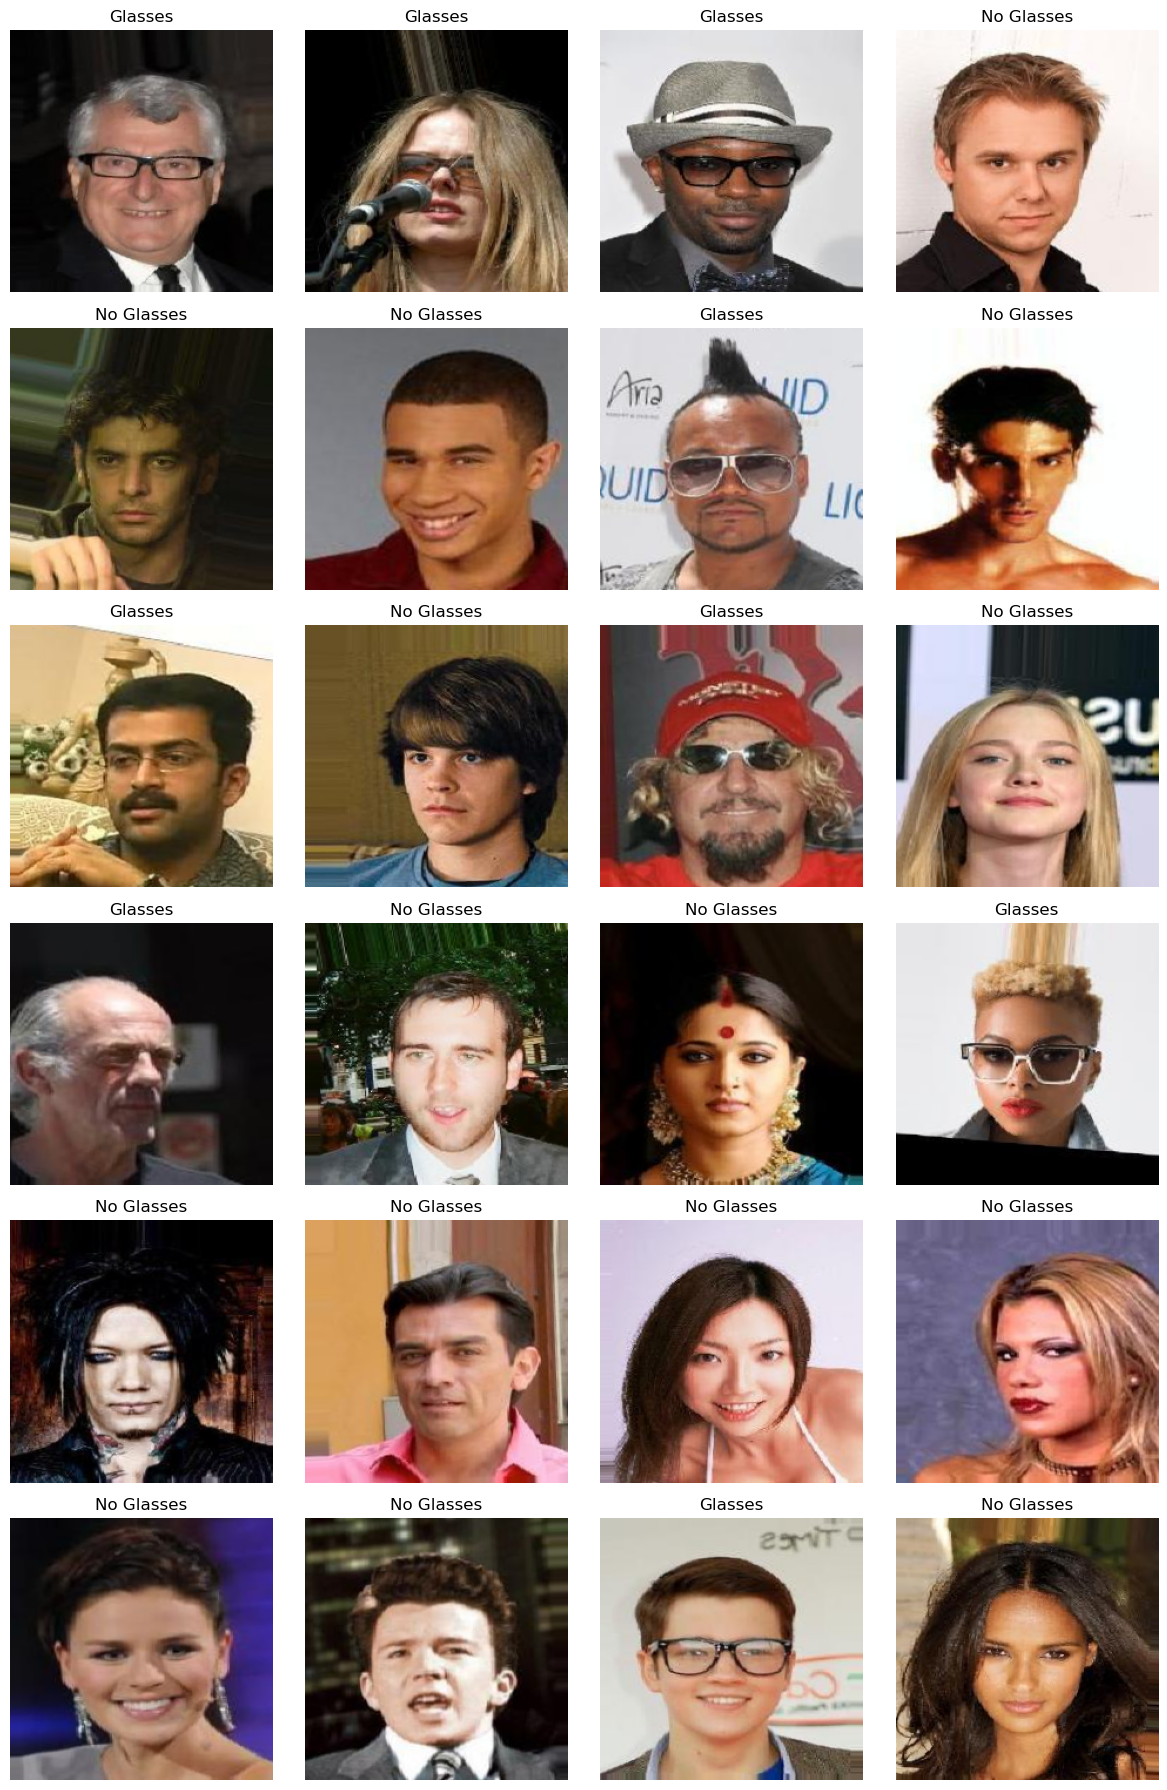

In [20]:
x_batch, y_batch = next(train_gen)
num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    label = "Glasses" if y_batch[i] == 0 else "No Glasses"
    ax.set_title(label)
    ax.axis('off')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Set up and configure a model for training

In [21]:
# These two models are also not bad
# base_model = MobileNet(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Is correct on the test data, but not on my own
# base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) # Works for my images, but isn't correct on the test data

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# base_model.trainable = False

base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# model = Sequential([
#     Conv2D(32, kernel_s, activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001), padding="VALID"),
#     MaxPooling2D((2,2)),

#     Conv2D(64, kernel_s, activation='relu'),
#     MaxPooling2D((2,2)),

#     Conv2D(64, kernel_s, activation='relu'),
#     MaxPooling2D((2,2)),

#     Conv2D(128, kernel_s, activation='relu'),
#     MaxPooling2D((2,2)),

#     Conv2D(128, kernel_s, activation='relu'),
#     MaxPooling2D((2,2)),

#     # Last layer decise -> preparation for this = some layers before
#     Flatten(),
#     Dense(1024, activation='relu'),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_10 (Flatten)        (None, 51200)             0         
                                                                 
 dense_20 (Dense)            (None, 1024)              52429824  
                                                                 
 dropout_10 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 1)                 1025      
                                                                 
Total params: 74233633 (283.18 MB)
Trainable params: 59604161 (227.37 MB)
Non-trainable params: 14629472 (55.81 MB)
_________________________________________________________________


# Compile the model and start the training

In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(
    train_gen,
    batch_size=batch_size,
    epochs=40,
    validation_data=valid_gen,
    steps_per_epoch=100,
    callbacks=[early_stopping]
)

Epoch 1/40
100/100 [==============================] - 29s 224ms/step - loss: 1.8435 - acc: 0.8704 - val_loss: 0.6566 - val_acc: 0.8512
Epoch 2/40
100/100 [==============================] - 21s 214ms/step - loss: 0.1035 - acc: 0.9653 - val_loss: 0.0641 - val_acc: 0.9825
Epoch 3/40
100/100 [==============================] - 21s 212ms/step - loss: 0.0898 - acc: 0.9695 - val_loss: 0.0572 - val_acc: 0.9837
Epoch 4/40
100/100 [==============================] - 21s 211ms/step - loss: 0.0975 - acc: 0.9679 - val_loss: 0.0625 - val_acc: 0.9837
Epoch 5/40
100/100 [==============================] - 21s 209ms/step - loss: 0.0780 - acc: 0.9771 - val_loss: 0.1026 - val_acc: 0.9787
Epoch 6/40
100/100 [==============================] - 21s 211ms/step - loss: 0.0643 - acc: 0.9799 - val_loss: 0.0712 - val_acc: 0.9800
Epoch 7/40
100/100 [==============================] - 21s 209ms/step - loss: 0.0498 - acc: 0.9854 - val_loss: 0.0643 - val_acc: 0.9812
Epoch 8/40
100/100 [==============================] - 2

# Data Augmenation Pipeline

In [11]:
def generate_random_config():
    return {
        'rotation': random.uniform(0, 10),             
        'zoom': random.uniform(0, 0.25),             
        'width_shift': random.uniform(0, 0.1),
        'height_shift': random.uniform(0, 0.1),
        'shear': random.uniform(0, 0.1),           
        'hflip': True,                                
        'brightness': random.choice([[0.7, 1.3], [0.8, 1.2], None]) 
}

results = []

for i in range(10):
    config = generate_random_config()
    print(f"\n[INFO] Running config {i+1}: {config}")
    pipeline = DataAugmentationPipeline(config=config, batch_size=batch_size, target_size=target_size, class_mode='binary')
    
    train_gen = pipeline.get_train_generator()
    valid_gen = pipeline.get_valid_generator()
    test_gen = pipeline.get_test_generator()
    
    # Build the model for each iteration new
    base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # base_model.trainable = False

    base_model.trainable = True
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc'])

    history = model.fit(
        train_gen,
        batch_size=batch_size,
        epochs=40,
        validation_data=valid_gen,
        steps_per_epoch=100,
        callbacks=[early_stopping]
    )
    
    # Evaluate on test dataset
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    
    results.append({
        'config': config,
        'val_acc': max(history.history['val_acc']),
        'test_acc': test_acc,
        'history': history.history
    })

# Sorted after best test accuracy
results = sorted(results, key=lambda x: x['test_acc'], reverse=True)

for r in results:
    print(f"\nConfig: {r['config']}\n-> Val Acc: {r['val_acc']:.4f} | Test Acc: {r['test_acc']:.4f}")


[INFO] Running config 1: {'rotation': 6.733787228770899, 'zoom': 0.11582383344107686, 'width_shift': 0.03212384336191026, 'height_shift': 0.048905757401982136, 'shear': 0.07831471428027012, 'hflip': True, 'brightness': None}
Found 6400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


2025-07-10 05:53:28.606513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46733 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:17:00.0, compute capability: 8.6


Epoch 1/40


2025-07-10 05:53:37.316060: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-07-10 05:53:41.055485: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f10a09645c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-10 05:53:41.055523: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-07-10 05:53:41.061644: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752126821.186466     974 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 38s 254ms/step - loss: 2.0562 - acc: 0.8829 - val_loss: 0.3643 - val_acc: 0.9712
Epoch 2/40
100/100 [==============================] - 23s 230ms/step - loss: 0.2336 - acc: 0.9457 - val_loss: 0.0854 - val_acc: 0.9737
Epoch 3/40
100/100 [==============================] - 21s 214ms/step - loss: 0.1146 - acc: 0.9632 - val_loss: 0.0723 - val_acc: 0.9750
Epoch 4/40
100/100 [==============================] - 22s 215ms/step - loss: 0.0894 - acc: 0.9699 - val_loss: 0.0962 - val_acc: 0.9588
Epoch 5/40
100/100 [==============================] - 22s 215ms/step - loss: 0.1020 - acc: 0.9678 - val_loss: 0.0504 - val_acc: 0.9850
Epoch 6/40
100/100 [==============================] - 21s 214ms/step - loss: 0.0715 - acc: 0.9791 - val_loss: 0.0582 - val_acc: 0.9775
Epoch 7/40
100/100 [==============================] - 21s 211ms/step - loss: 0.0570 - acc: 0.9778 - val_loss: 0.0704 - val_acc: 0.9775
Epoch 8/40
100/100 [==============================] - 21s 211ms/st

# Plot the results of the training with a Data Augmentation Pipeline

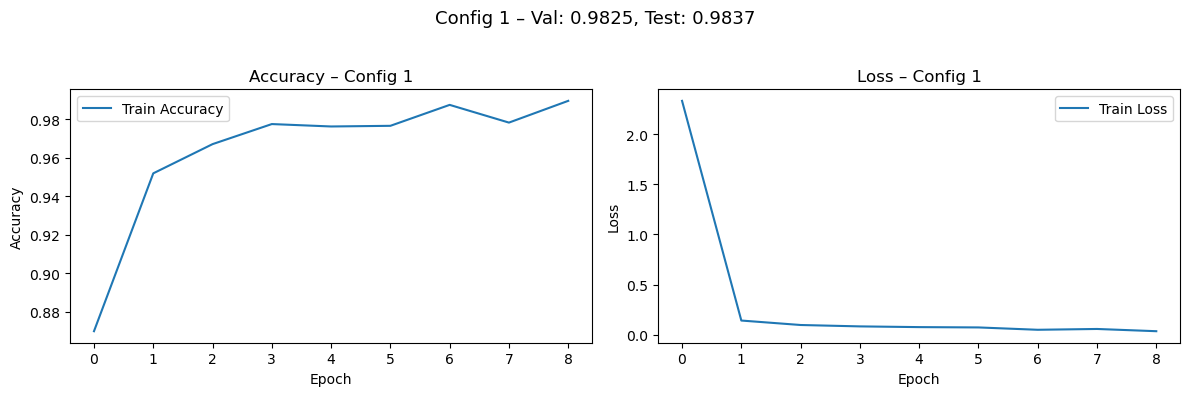

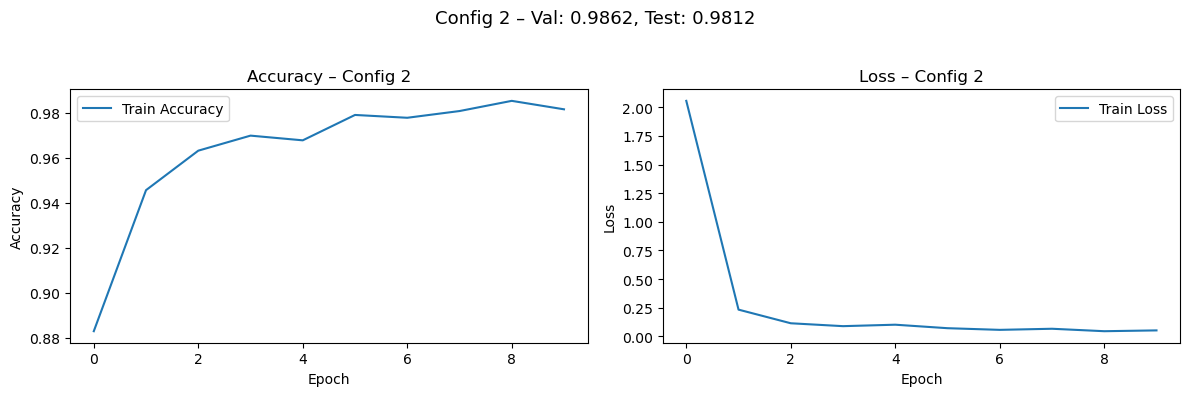

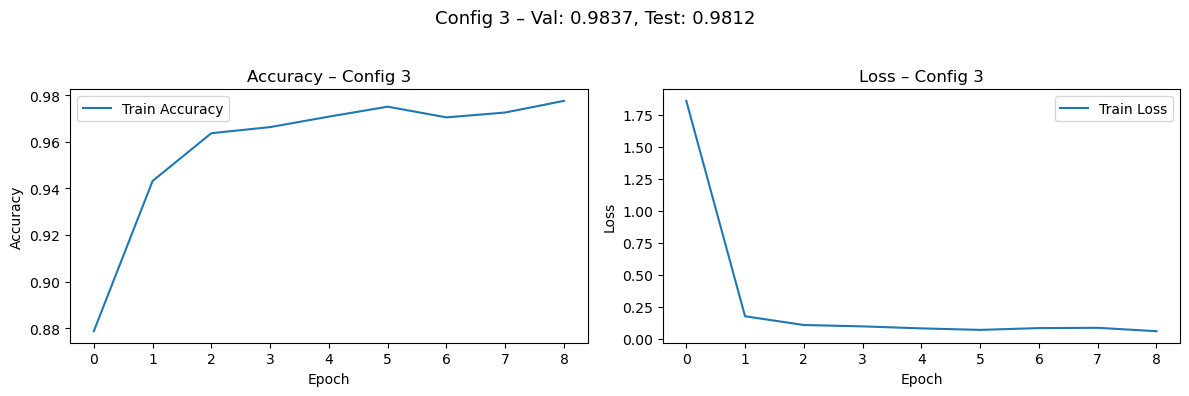

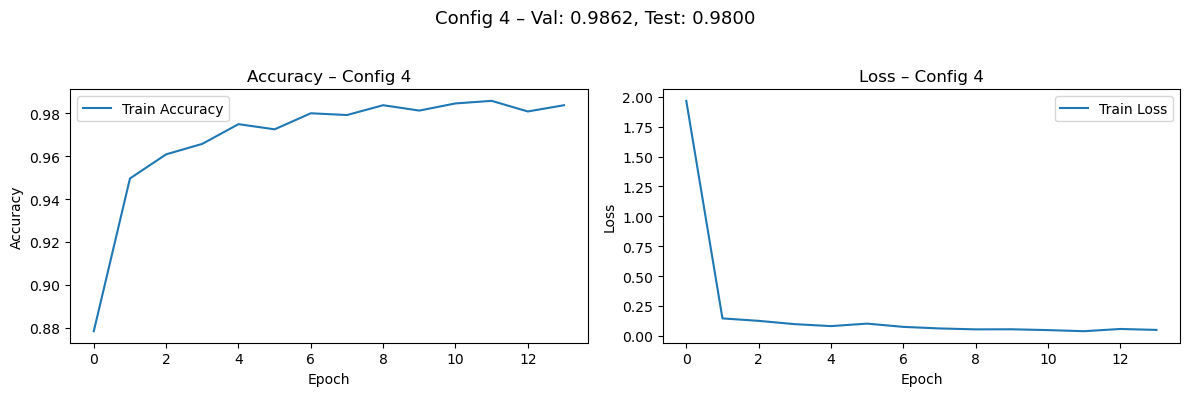

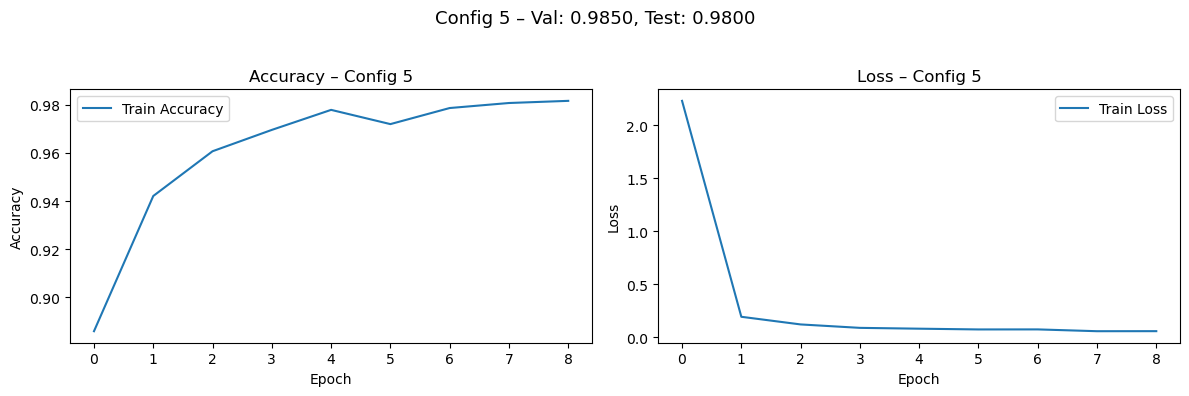

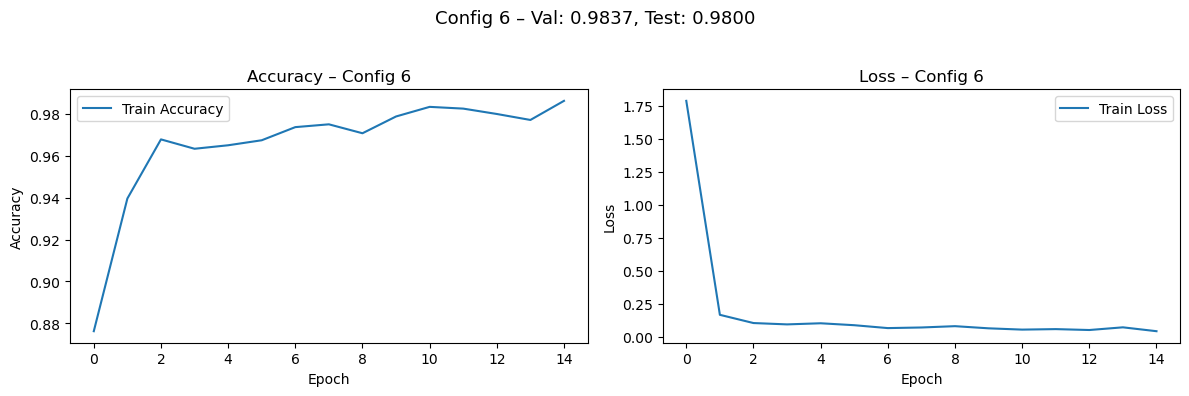

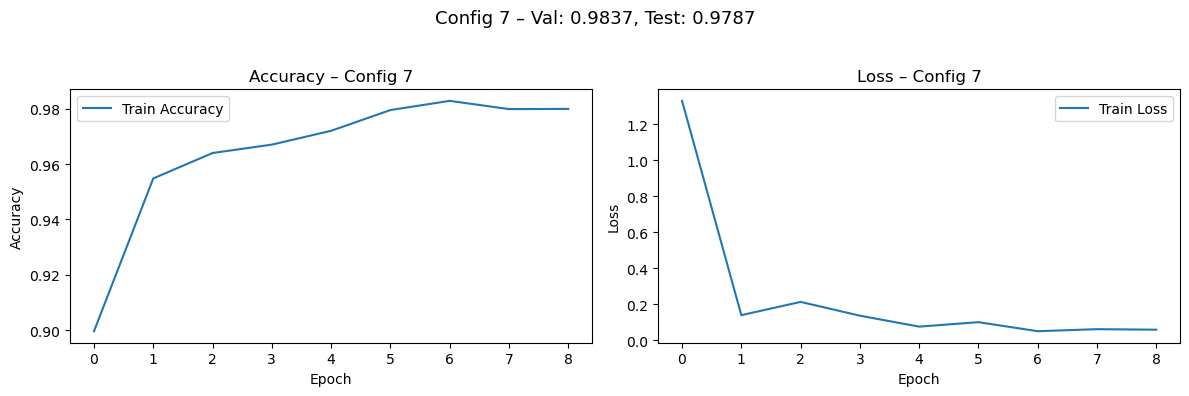

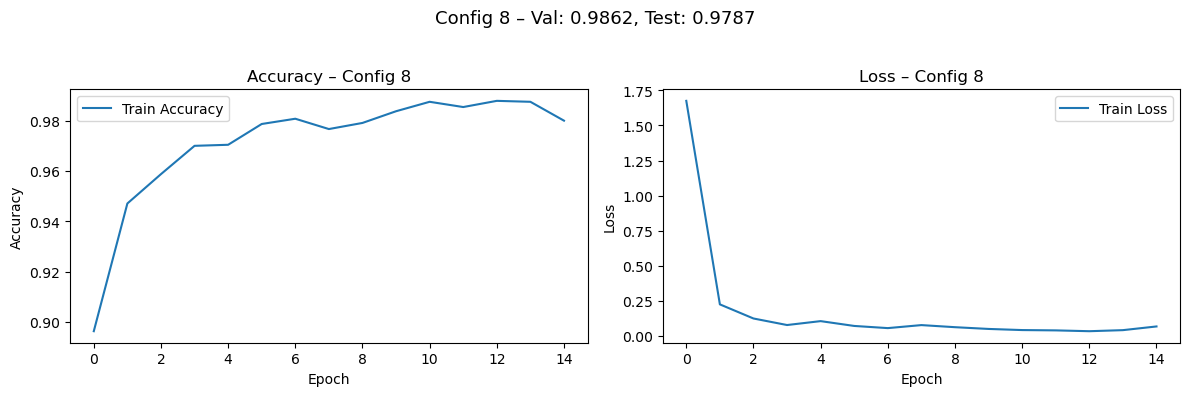

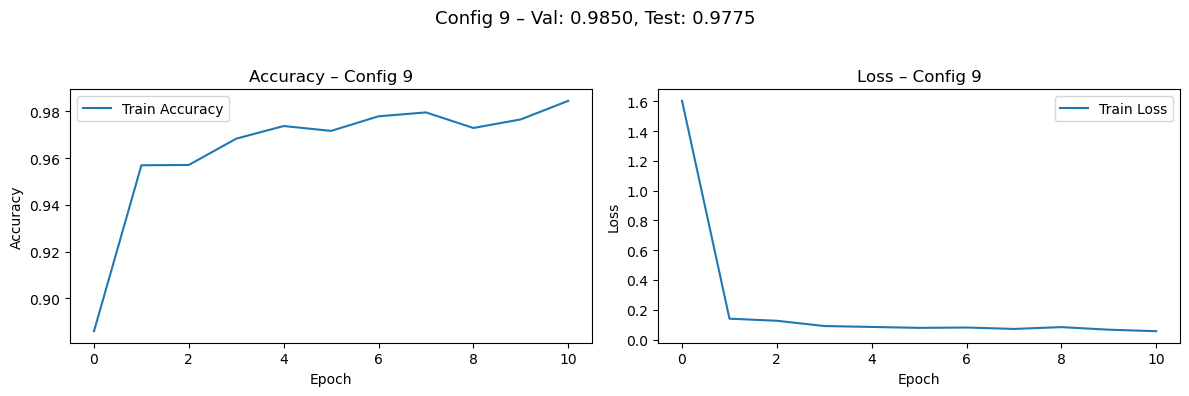

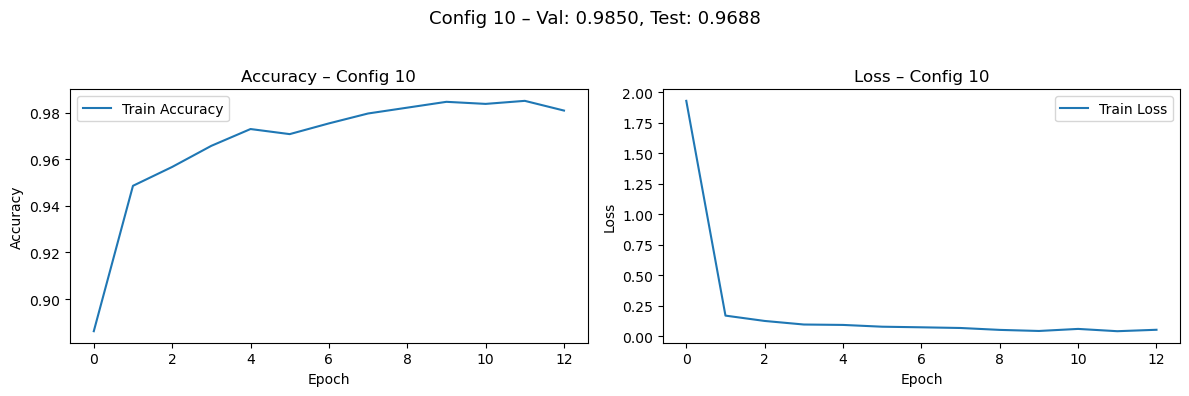

In [12]:
for i, r in enumerate(results):
    history = r.get('history', None)
    
    if history is None:
        print(f"[WARNING] No training history for config {i+1} available – please log the history.")
        continue

    config = r['config']
    val_acc = r['val_acc']
    test_acc = r['test_acc']

    acc_key = 'accuracy' if 'accuracy' in history else 'acc'
    val_acc_key = 'val_accuracy' if 'val_accuracy' in history else 'val_acc'

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history[acc_key], label='Train Accuracy')
    plt.title(f'Accuracy – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.title(f'Loss – Config {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.suptitle(f'Config {i+1} – Val: {val_acc:.4f}, Test: {test_acc:.4f}', fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot the results of the training

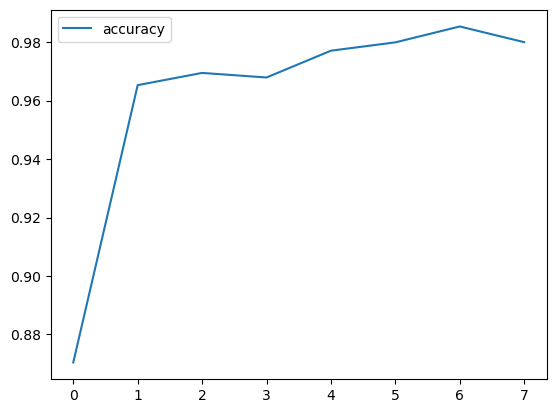

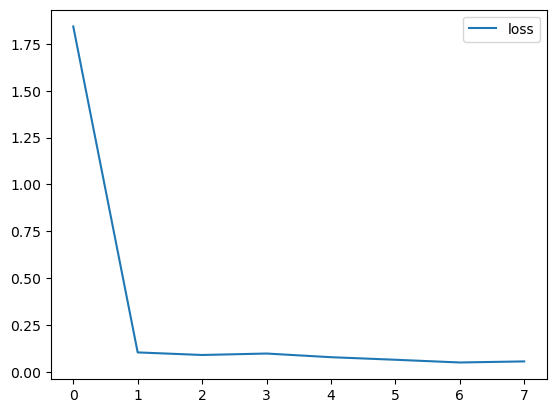

In [23]:
plt.plot(history.history['acc'], label='accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.legend()

# Test the model on the test data

1/1 [==============================] - 1s 1s/step


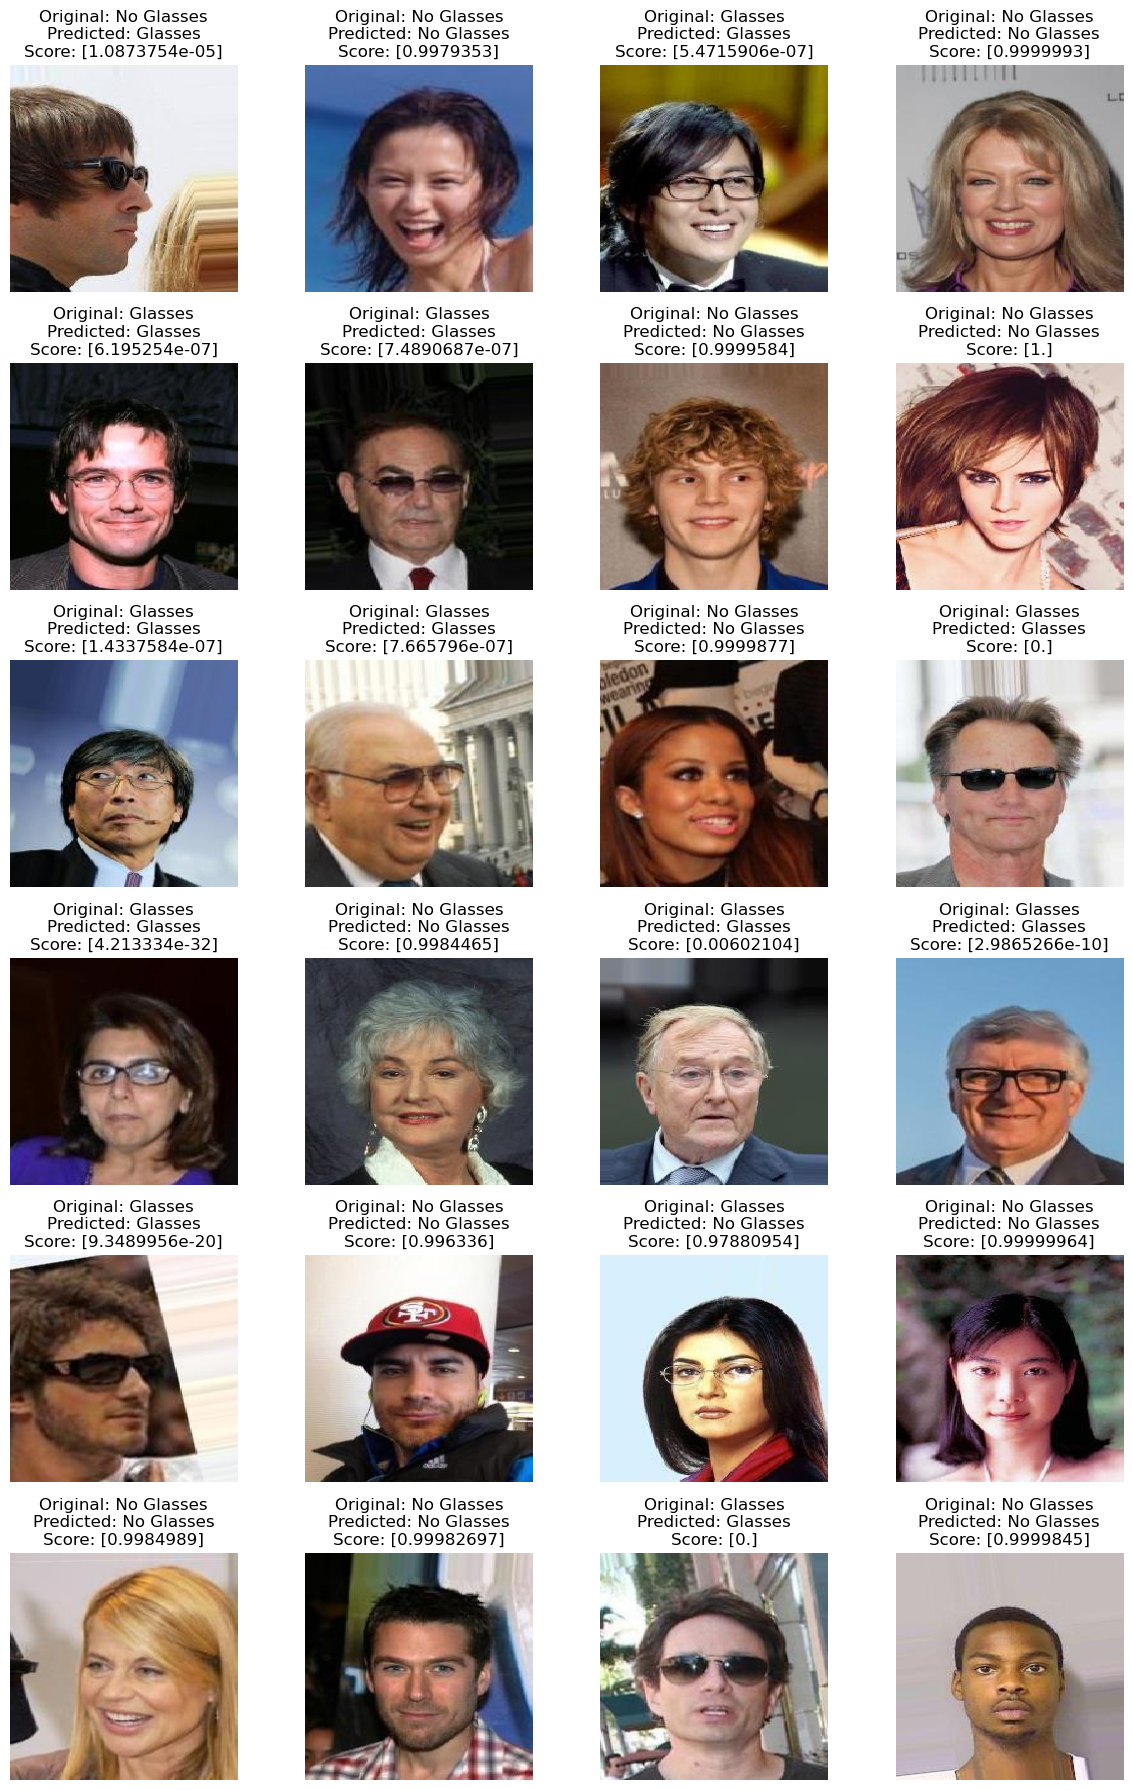

In [24]:
x_batch, y_batch = next(test_gen)
predictions = model.predict(x_batch)

# print(f"Predictions {predictions}")
predicted_labels = (predictions > 0.5).astype(int).flatten()
# print(predicted_labels)

num_images = x_batch.shape[0]
cols = 4
rows = (num_images + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))
axes = axes.flatten()

class_names = ["Glasses", "No Glasses"]

for i in range(num_images):
    ax = axes[i]
    ax.imshow(x_batch[i])
    
    true_label = class_names[int(y_batch[i])]
    predicted_label = class_names[predicted_labels[i]]
    
    ax.set_title(f"Original: {true_label}\nPredicted: {predicted_label}\nScore: {predictions[i]}")
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Test the model on my own data

1/1 [==============================] - 1s 1s/step


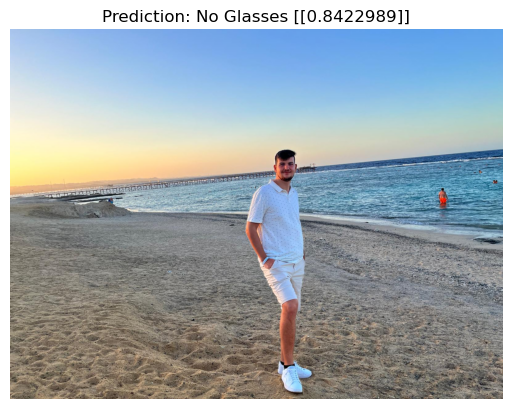

1/1 [==============================] - 0s 32ms/step


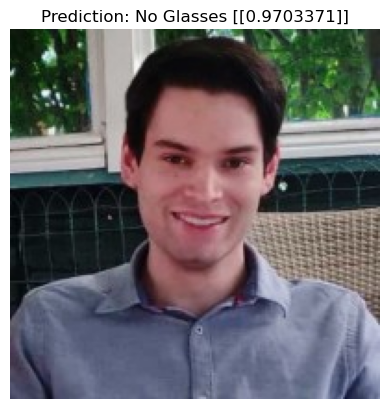

1/1 [==============================] - 0s 33ms/step


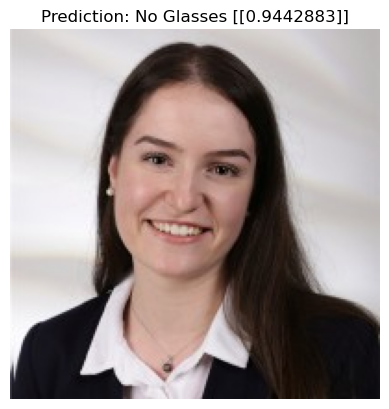

1/1 [==============================] - 0s 34ms/step


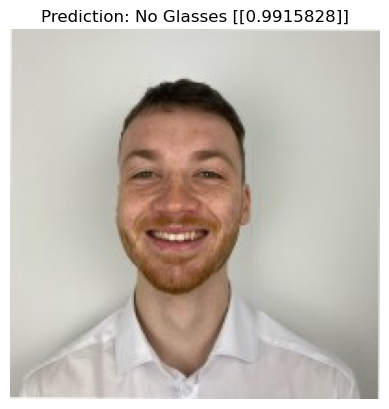

In [25]:
def edit_image(image_path: str) -> np.array: 
    img = load_img(image_path, target_size=target_size)

    img_array = img_to_array(img)
    img_array = img_array / 255.0 

    img_array = np.expand_dims(img_array, axis=0)
    
    return img_array

class_names = ["Glasses", "No Glasses"]

images = glob.glob('../Images/*.jpg')

for i, image in enumerate(images):
    img_array = edit_image(image)
    
    prediction = model.predict(img_array)
    predicted_labels = (prediction > 0.5).astype(int).flatten()
    predicted_label = class_names[predicted_labels[0]]

    plt.imshow(load_img(image))
    plt.title(f"Prediction: {predicted_label} {prediction}")
    plt.axis("off")
    plt.show()

# Evaluate the model ans save it to a file

In [26]:
model.evaluate(test_gen)
model.save("../Models/With_DA_Pipeline/Glasses_classification")

34/34 [==============================] - 1s 34ms/step - loss: 0.0770 - acc: 0.9850
INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Glasses_classification/assets


INFO:tensorflow:Assets written to: ../Models/With_DA_Pipeline/Glasses_classification/assets


# Test the model on detected and extracted faces

Loading the model: Glasses_classification
Predicting with the model which was trained with the pipeline:
1/1 [==============================] - 1s 1s/step


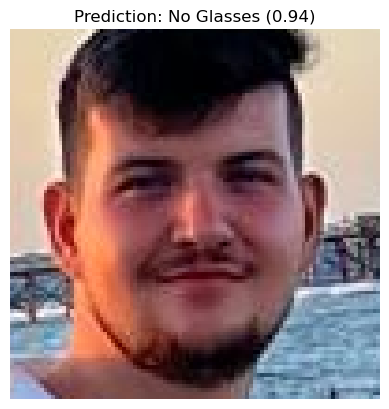

1/1 [==============================] - 0s 32ms/step


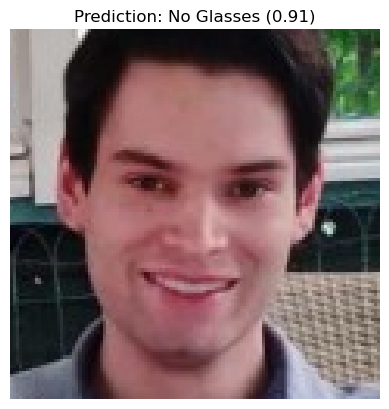

1/1 [==============================] - 0s 35ms/step


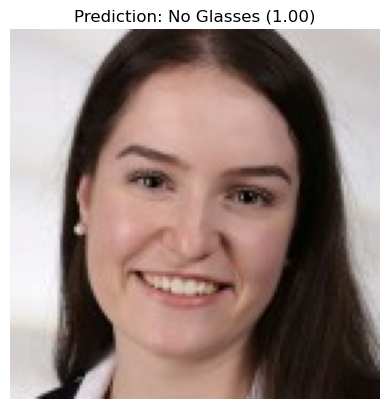

1/1 [==============================] - 0s 35ms/step


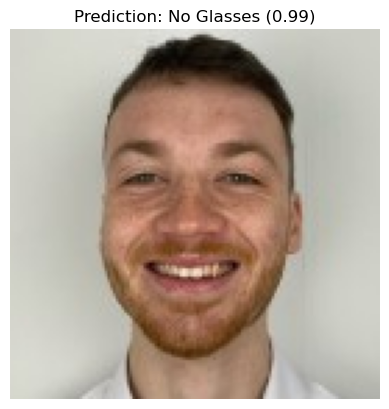

Predicting with the model which was trained without the pipeline:
1/1 [==============================] - 1s 1s/step


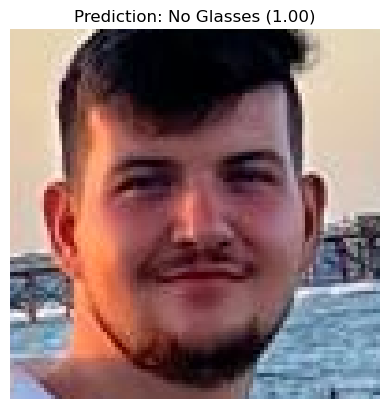

1/1 [==============================] - 0s 34ms/step


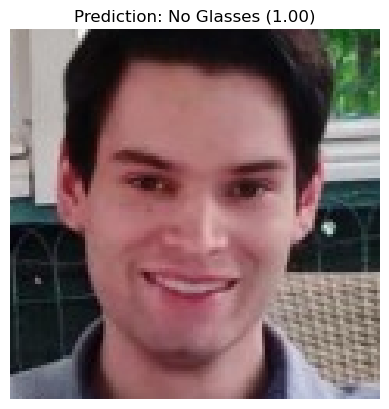

1/1 [==============================] - 0s 33ms/step


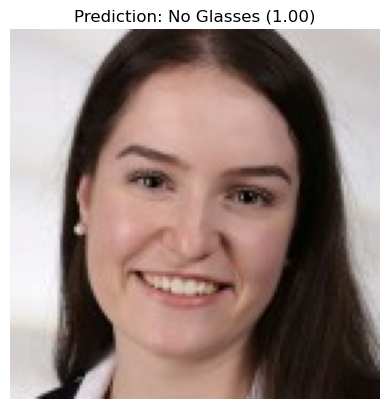

1/1 [==============================] - 0s 32ms/step


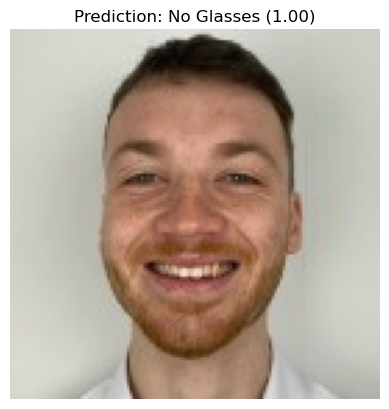

In [29]:
print(f"Loading the model: Glasses_classification")
model_with_pipeline = load_model("../Models/With_DA_Pipeline/Glasses_classification")
model_without_pipeline = load_model("../Models/Without_DA_Pipeline/Glasses_classification")

print("Predicting with the model which was trained with the pipeline:")
predict_detected_faces(model=model_with_pipeline, class_names=class_names, padding=0.2, image_directory="../Images/*.jpg")

print("Predicting with the model which was trained without the pipeline:")
predict_detected_faces(model=model_without_pipeline, class_names=class_names, padding=0.2, image_directory="../Images/*.jpg")